<a href="https://colab.research.google.com/github/ArnaudDavyMM/Time-Series-Analyis/blob/master/Store_Sales_Timeseries_Forecast_Prophet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 2.2

In this section we are going to focus on Time Series Analysis and Forecasting using Facebook Prophet algorithm because we already dived deep into EDA(Exploratory data Analysis in the first section of the project.

## Import Libraries

In [ ]:
# Import warnings
import warnings
warnings.simplefilter('ignore')   
warnings.filterwarnings('ignore', category = DeprecationWarning) 
warnings.filterwarnings('ignore', category = UserWarning) 
warnings.simplefilter("ignore", FutureWarning, )

# Data Manipulation & Preprocessing
import datetime
import itertools
import numpy as np
import pandas as pd
import scipy.stats as stats
from datetime import datetime
from sklearn.preprocessing import *

# Data Visualization
import seaborn as sbn
import matplotlib.pyplot as plt
sbn.set(rc={'figure.figsize':(12,8)})

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pandas.plotting import scatter_matrix

# Time series
import statsmodels.api as sm
from statsmodels.tsa.api import *
from statsmodels.tsa.stattools import *
from statsmodels.graphics.tsaplots import *
from statsmodels.tsa.statespace.varmax import *
from statsmodels.tsa.seasonal import *

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import *  # (plot_plotly, plot_components_plotly, add_changepoints_to_plot , plot_cross_validation_metric)


# EVALUATION METRICS
from sklearn.metrics import *
from sklearn.model_selection import *

## 1. Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount =True)

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Retail_train_data.csv', 
                       parse_dates =['Date'],
                       infer_datetime_format = True,
                       low_memory = False)

In [ ]:
print('Training data Rows : %s and Columns : %s ' % (str(train_df.shape[0]) ,str(train_df.shape[1])))

Training data Rows : 982644 and Columns : 9 


In [ ]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [ ]:
train_df.columns = train_df.columns.str.lower()

In [ ]:
train_df.sort_values('date', ascending =True, inplace =True)

In [ ]:
train_df.head()

,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday
982643,1115,2,2013-01-01,0,0,0,0,a,1
981908,379,2,2013-01-01,0,0,0,0,a,1
981907,378,2,2013-01-01,0,0,0,0,a,1
981906,377,2,2013-01-01,0,0,0,0,a,1
981905,376,2,2013-01-01,0,0,0,0,a,1


In [ ]:
train_df.tail()

,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday
745,746,2,2015-06-30,8082,598,1,1,0,0
746,747,2,2015-06-30,10850,770,1,1,0,0
747,748,2,2015-06-30,9862,654,1,1,0,1
741,742,2,2015-06-30,11505,996,1,1,0,1
0,1,2,2015-06-30,5735,568,1,1,0,0


## 2. EDA (Exploratory Data Analysis)

*   Remember that the EDA was done in Part 1 of this project.So we are going to focus only on Time series Analys and forcast



In [ ]:
# create training subset were stores are opened and have sales
train_sales = train_df[(train_df.sales != 0) & (train_df.open != 0)]
train_sales.shape

(814150, 9)

In [ ]:
pd.set_option('display.float_format','{:.3f}'.format)

In [ ]:
print('Skewness:{:0.3f}'.format(train_df['sales'].skew()))

Skewness:0.646


In [ ]:
train_sales['logsales'] =np.log(train_sales.sales)

In [ ]:
train_sales.sample(3)

,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday,logsales
611602,253,5,2013-11-29,7576,795,1,0,0,0,8.933
28267,393,5,2015-06-05,7311,732,1,1,0,0,8.897
337281,987,6,2014-08-09,3743,511,1,0,0,0,8.228


In [ ]:
train_sales.set_index('date', inplace =True)

In [ ]:
train_sales['date'] = train_sales.index

## Prepare dataset for Prophet algorithm

### Log Transformation on Sales

As seen in EDA section, our target variable is asymetric (not normally distributed) and right-skewed. There are various methods to solve the issue such as  removing outliers,normalization, standardization and transformation.

For our projwect we are going to use transformation method precisely log transformation.

In [ ]:
train_sales.rename(columns ={'sales':'y','date':'ds'}, inplace =True)

In [ ]:
train_sales.sample(3)

,store,dayofweek,y,customers,open,promo,stateholiday,schoolholiday,logsales,ds
date,,,,,,,,,,
2014-06-16,856,1,8678,1096,1,1,0,0,9.069,2014-06-16
2013-09-14,832,6,5874,537,1,0,0,0,8.678,2013-09-14
2015-03-11,248,3,6700,983,1,0,0,0,8.810,2015-03-11


In [ ]:
all_store_ts = train_sales.loc[:,['ds','y']]

In [ ]:
all_store_ts.columns =['ds','y']

In [ ]:
all_store_ts.head()

,ds,y
date,,
2013-01-01,2013-01-01,3139
2013-01-01,2013-01-01,2401
2013-01-01,2013-01-01,2646
2013-01-01,2013-01-01,3113
2013-01-01,2013-01-01,2907


In [ ]:
all_store_ts.tail()

,ds,y
date,,
2015-06-30,2015-06-30,8082
2015-06-30,2015-06-30,10850
2015-06-30,2015-06-30,9862
2015-06-30,2015-06-30,11505
2015-06-30,2015-06-30,5735


In [ ]:
m = Prophet()

In [ ]:
m.fit(all_store_ts)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/ci5xnmhv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/0c8100o1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63863', 'data', 'file=/tmp/tmpajaw3sod/ci5xnmhv.json', 'init=/tmp/tmpajaw3sod/0c8100o1.json', 'output', 'file=/tmp/tmpajaw3sod/prophet_modelxwou73of/prophet_model-20230116181037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:19:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods =365)
future.head()

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


In [ ]:
future.tail()

,ds
1271,2016-06-25
1272,2016-06-26
1273,2016-06-27
1274,2016-06-28
1275,2016-06-29


In [ ]:
forecast =m.predict(future)

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
1269,2016-06-23,5924.367,-9293.748,22504.942
1270,2016-06-24,6194.181,-9081.164,23543.956
1271,2016-06-25,4968.706,-10878.277,21295.074
1272,2016-06-26,7273.051,-9155.011,24203.102
1273,2016-06-27,7285.405,-8596.120,23827.313
1274,2016-06-28,6141.382,-10594.147,22925.569
1275,2016-06-29,5778.812,-10458.651,22882.189


**Note that:**

Below is a trend and pattern of data from the forcast

    . Black dots are the actual values or actual data points of/in our dataset
    . Deep blue line is the predicted values or the predicted forecast
    . Light blue line is the confidence interval

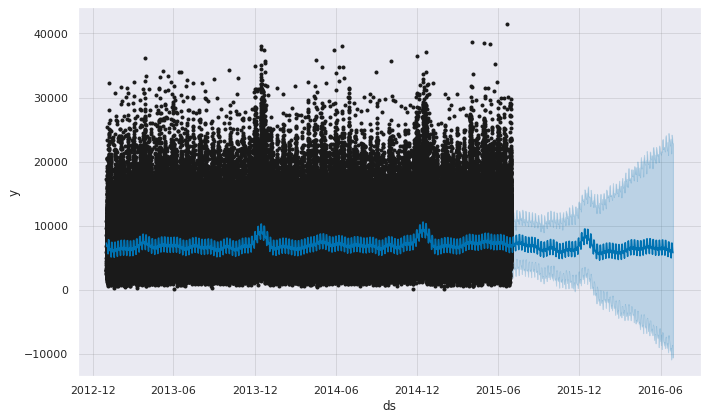

In [ ]:
fig =m.plot(forecast)

As seen above there are lots of outliers on the graph. It will be wise to pick arbitraily a particular store and perform prediction (forecast) rather than all store.

In [ ]:
fig =plot_components_plotly(m, forecast)
fig.show()

The trend is constant throughout the year. Monthly trend and patter remain the as per time series analysis we perform on the previous section.

**Note that:**

    . yhat is the prediction (the predicted forecast)
    . yhat_lower is the lower border of the prediction
    . yhat_upper is the upper border of the prediction

### Store 262

Going to choose the store 262 for prediction because it has the highest sales on average among all other.

Feel free to pick arbitrairly any store.

In [ ]:
store_262 = train_sales[train_sales.store.isin([262])]

In [ ]:
# LET'S COMPARE THE SHAPE 
print(f'The shape for the subset logts is : {all_store_ts.shape}')
print(f'The shape for the subset store_262 is : {store_262.shape}')

The shape for the subset logts is : (814150, 2)
The shape for the subset store_262 is : (911, 10)


In [ ]:
store_262_ts = store_262.loc[:, ['ds', 'y']]

In [ ]:
store_262_ts.head()

,ds,y
date,,
2013-01-01,2013-01-01,17267
2013-01-02,2013-01-02,16964
2013-01-03,2013-01-03,16616
2013-01-04,2013-01-04,16849
2013-01-05,2013-01-05,14868


In [ ]:
store_262_ts.tail()

,ds,y
date,,
2015-06-26,2015-06-26,17936
2015-06-27,2015-06-27,17864
2015-06-28,2015-06-28,28817
2015-06-29,2015-06-29,20112
2015-06-30,2015-06-30,21554


In [ ]:
store_262_m = Prophet()
store_262_m.fit(store_262_ts)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/j4uxnmog.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/cfzdm9zs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12694', 'data', 'file=/tmp/tmpajaw3sod/j4uxnmog.json', 'init=/tmp/tmpajaw3sod/cfzdm9zs.json', 'output', 'file=/tmp/tmpajaw3sod/prophet_model1qb0799n/prophet_model-20230116181928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:19:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future262 = store_262_m.make_future_dataframe(periods =365)
future262.tail()

,ds
1271,2016-06-25
1272,2016-06-26
1273,2016-06-27
1274,2016-06-28
1275,2016-06-29


In [ ]:
forecast262 = store_262_m.predict(future262)

In [ ]:
forecast262[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
1269,2016-06-23,19308.318,15403.757,22919.075
1270,2016-06-24,20705.511,16933.257,24517.130
1271,2016-06-25,16927.440,13259.556,20581.566
1272,2016-06-26,27638.193,24110.744,31450.452
1273,2016-06-27,19773.381,16047.775,23668.795
1274,2016-06-28,17877.839,13598.960,21568.906
1275,2016-06-29,17662.923,13764.695,21547.940


In [ ]:
plot_plotly(store_262_m, forecast262)

In [ ]:
plot_components_plotly(store_262_m, forecast262)

In the above graph, we can see that the trend is decreasing throughout the year which seems to back up the trend for all store. 
However, there is not need to jump into conclusion at the first impression, we need to access all possibilties and assumptions we have such as:


1.   Adding seasonality will have effect on sales?
2.   Adding holidays effects will have effect on sales?
3.   Adding regressors will have effect on sales?
4.   Detection change points and adjusting trends will lead to be best results?



## Seasonality Effects



### 1.  Seasonality effects for all store model

In [ ]:
# Seasonality for all store model
seas_m = Prophet(weekly_seasonality=False)
seas_m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
seas_m_forecast = seas_m.fit(all_store_ts).predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/yzfb1zy3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/qsi8h6xn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16698', 'data', 'file=/tmp/tmpajaw3sod/yzfb1zy3.json', 'init=/tmp/tmpajaw3sod/qsi8h6xn.json', 'output', 'file=/tmp/tmpajaw3sod/prophet_model5r7f4_br/prophet_model-20230116182035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
plot_components_plotly(seas_m, forecast)

### 2.  Seasonality effect for store 262 model

In [ ]:
#Monthly seasonal
seas_m1 = Prophet(weekly_seasonality=False)
seas_m1.add_seasonality(name='monthly', period =30.5, fourier_order=5)
seas_m1_forecast = seas_m1.fit(store_262_ts).predict(future262)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/ycobgkjg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/2xjus324.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91340', 'data', 'file=/tmp/tmpajaw3sod/ycobgkjg.json', 'init=/tmp/tmpajaw3sod/2xjus324.json', 'output', 'file=/tmp/tmpajaw3sod/prophet_model4fmce1y5/prophet_model-20230116182713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
plot_components_plotly(seas_m1, seas_m1_forecast)

As seen above, it is worth saying that the store doesn't record high sales based on January.But we can see December, May,June and April record sales.

It will wise to add holidays effects to see if there will have any positive effects on sales.

## Holidays Effects

### State and School Holidays for store 262

In [ ]:
# create holidays dataframe
stateholidays = train_sales[(train_sales.stateholiday == 1) |(train_sales.stateholiday == 2) & (train_sales.stateholiday == 3)].loc[:, 'ds'].values
schoolholiday = train_sales[train_sales.schoolholiday == 1].loc[:, 'ds'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(stateholidays)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(schoolholiday)})

state_school_holidays = pd.concat((state, school))      
state_school_holidays.head()

,holiday,ds
0,school_holiday,2013-01-01
1,school_holiday,2013-01-01
2,school_holiday,2013-01-01
3,school_holiday,2013-01-01
4,school_holiday,2013-01-01


In [ ]:
state_school_holidays.tail()

,holiday,ds
150708,school_holiday,2015-06-30
150709,school_holiday,2015-06-30
150710,school_holiday,2015-06-30
150711,school_holiday,2015-06-30
150712,school_holiday,2015-06-30


In [ ]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
holidays_m = Prophet(interval_width = 0.95, 
                     holidays = state_school_holidays)

holidays_m.fit(store_262)

# dataframe that extends into future 6 weeks 
future2 = holidays_m.make_future_dataframe(periods = 365)

print("First week to forecast.")
future2.tail(7)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/zubg6n_8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/2b3_r_au.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79597', 'data', 'file=/tmp/tmpajaw3sod/zubg6n_8.json', 'init=/tmp/tmpajaw3sod/2b3_r_au.json', 'output', 'file=/tmp/tmpajaw3sod/prophet_model1x291zad/prophet_model-20230116182733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


First week to forecast.


,ds
1269,2016-06-23
1270,2016-06-24
1271,2016-06-25
1272,2016-06-26
1273,2016-06-27
1274,2016-06-28
1275,2016-06-29


In [ ]:
# predictions
forecast2 = holidays_m.predict(future2)

# preditions for last week
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)


,ds,yhat,yhat_lower,yhat_upper
1269,2016-06-23,18992.818,13647.338,24772.658
1270,2016-06-24,20365.033,14701.811,26261.820
1271,2016-06-25,16898.221,11194.212,22354.311
1272,2016-06-26,27588.955,21915.003,33427.945
1273,2016-06-27,19420.233,13777.966,24918.338
1274,2016-06-28,17487.421,11823.331,23574.802
1275,2016-06-29,17249.064,11331.156,22688.129


In [ ]:
plot_plotly(holidays_m, forecast2)

In [ ]:
plot_components_plotly(holidays_m, forecast2)

As seen above the graph decomposition, it's clear to conclude that the store 262 performs well on monthly basis and specialy on school holidays rather than on weekly basis. The highest sales happens to be on Friday.
December has the highest sales followed by May, June and April.

## Changepoint detection

### 1.  Change points for store_262 model

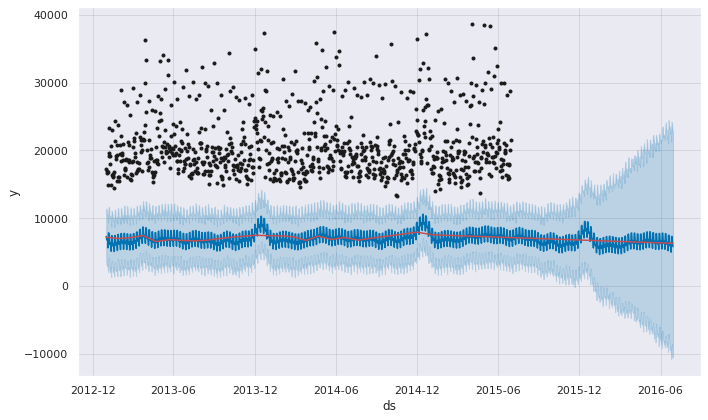

In [ ]:
fig = store_262_m.plot(forecast)
c = add_changepoints_to_plot(fig.gca(), 
                             store_262_m,
                             forecast)

As seen from the graph above, the model underfit, the predicted values are under the actual values.
We need to adjust the changepoints scale to solve the underfit issue.

### 2.  Adjusting Trend for store 262 model

In [ ]:
changepts_range= Prophet(changepoint_range =0.95, yearly_seasonality =True)
forecast = changepts_range.fit(store_262_ts).predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/04d0d31m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/ruivp5em.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20165', 'data', 'file=/tmp/tmpajaw3sod/04d0d31m.json', 'init=/tmp/tmpajaw3sod/ruivp5em.json', 'output', 'file=/tmp/tmpajaw3sod/prophet_modelzfsn4xbu/prophet_model-20230116182905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


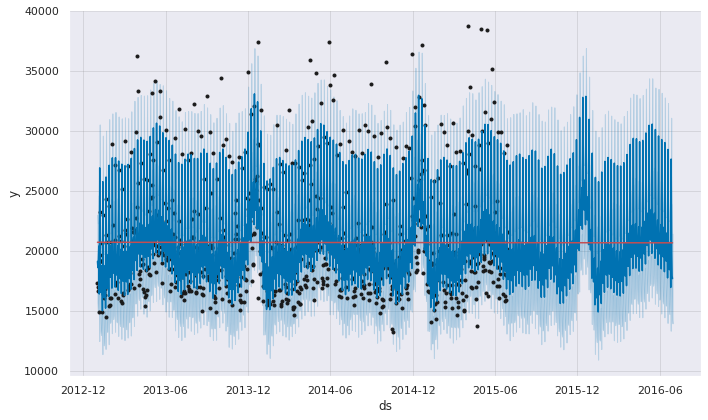

In [ ]:
fig= changepts_range.plot(forecast);
a = add_changepoints_to_plot(fig.gca(),changepts_range,forecast)

In [ ]:
changepts_range.changepoints

35    2013-02-05
69    2013-03-11
104   2013-04-15
138   2013-05-19
173   2013-06-23
207   2013-07-27
242   2013-08-31
276   2013-10-04
311   2013-11-08
346   2013-12-13
380   2014-01-16
415   2014-02-20
449   2014-03-26
484   2014-04-30
518   2014-06-03
553   2014-07-08
588   2014-08-12
622   2014-09-15
657   2014-10-20
691   2014-11-23
726   2014-12-28
760   2015-01-31
795   2015-03-07
829   2015-04-10
864   2015-05-15
Name: ds, dtype: datetime64[ns]

By default, Prophet adds 25 changepoints into the initial 80% of the dataset. The number of changepoints can be set by using the n_changepoints parameter when initializing prophet (e.g., model=Prophet(n_changepoints =20)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/aj0eq77w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/jlz9vf8a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15945', 'data', 'file=/tmp/tmpajaw3sod/aj0eq77w.json', 'init=/tmp/tmpajaw3sod/jlz9vf8a.json', 'output', 'file=/tmp/tmpajaw3sod/prophet_model8by5_oth/prophet_model-20230116182907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


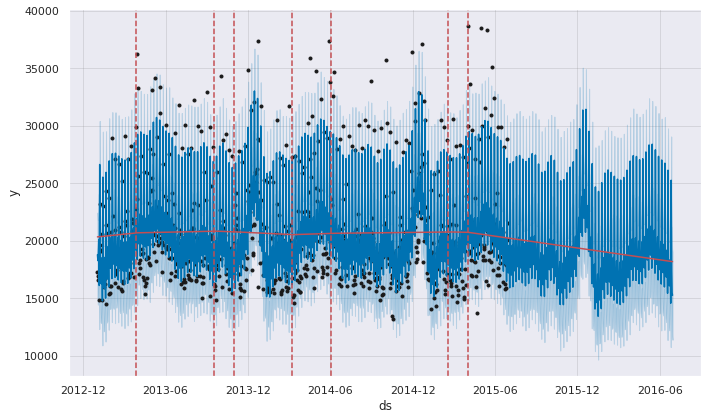

In [ ]:
changepts_scale= Prophet(n_changepoints =20, 
                         changepoint_range =0.95,
                         yearly_seasonality =True, 
                         changepoint_prior_scale =0.5)

forecast = changepts_scale.fit(store_262_ts).predict(future)
fig= changepts_scale.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), changepts_scale, forecast)

### 3. Change points for holidays model - State & School holidays

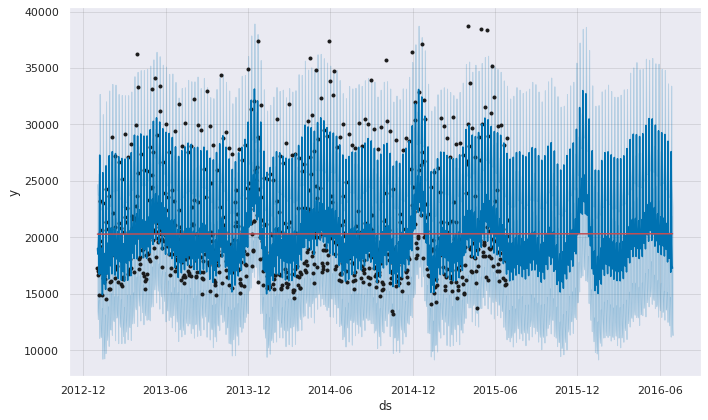

In [ ]:
fig2 = holidays_m.plot(forecast2)
c = add_changepoints_to_plot(fig2.gca(),
                             holidays_m,
                             forecast2)

## Adjusting Trend for holidays model

In [ ]:
holidays_changepts_scale= Prophet(n_changepoints =20, 
                                  changepoint_range =0.95, 
                                  yearly_seasonality =True, 
                                  changepoint_prior_scale =0.5)
forecast3 = holidays_changepts_scale.fit(store_262_ts).predict(future2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/a4bv2nf2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/d0olgg51.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84280', 'data', 'file=/tmp/tmpajaw3sod/a4bv2nf2.json', 'init=/tmp/tmpajaw3sod/d0olgg51.json', 'output', 'file=/tmp/tmpajaw3sod/prophet_modelzq53c0f4/prophet_model-20230116182909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


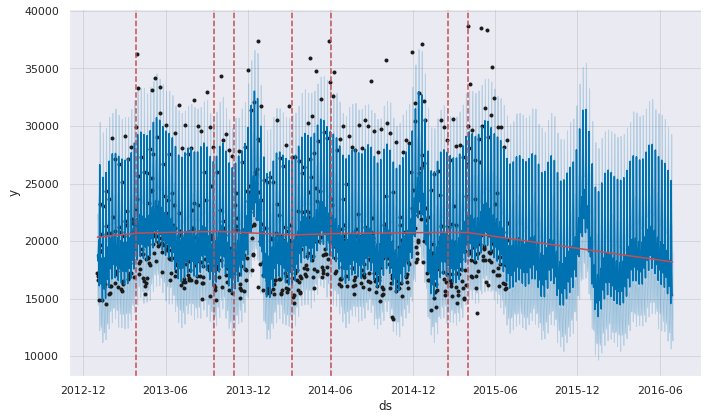

In [ ]:
fig= holidays_changepts_scale.plot(forecast3);
a = add_changepoints_to_plot(fig.gca(), 
                             holidays_changepts_scale,
                             forecast3)

In [ ]:
holidays_changepts_scale.changepoints

43    2013-02-13
86    2013-03-28
130   2013-05-11
173   2013-06-23
216   2013-08-05
259   2013-09-17
302   2013-10-30
346   2013-12-13
389   2014-01-25
432   2014-03-09
475   2014-04-21
518   2014-06-03
562   2014-07-17
605   2014-08-29
648   2014-10-11
691   2014-11-23
734   2015-01-05
778   2015-02-18
821   2015-04-02
864   2015-05-15
Name: ds, dtype: datetime64[ns]

## Add US Holidays

In [ ]:
us_hol_m = Prophet(holidays =state_school_holidays)
us_hol_m.add_country_holidays(country_name ='US')
us_hol_m.fit(store_262_ts)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/6wbqgc0x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/n9ya6rz0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6436', 'data', 'file=/tmp/tmpajaw3sod/6wbqgc0x.json', 'init=/tmp/tmpajaw3sod/n9ya6rz0.json', 'output', 'file=/tmp/tmpajaw3sod/prophet_model0nafxlz1/prophet_model-20230116182934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
us_hol_m.train_holiday_names

0                  school_holiday
1                  New Year's Day
2      Martin Luther King Jr. Day
3           Washington's Birthday
4                    Memorial Day
5                Independence Day
6                       Labor Day
7                    Columbus Day
8                    Veterans Day
9                    Thanksgiving
10                  Christmas Day
11    Independence Day (Observed)
dtype: object

In [ ]:
hol_future = us_hol_m.make_future_dataframe(periods = 365)

In [ ]:
hol_forecast = us_hol_m.predict(hol_future)
plot_components_plotly(us_hol_m, hol_forecast)

As seen above, we can conclude that overall, this model poorly performs on weekly basus. Only Friday has sales above zero even if the overall trend looks croisant.

Regarding us holidays, only Memorial day and Chrismas have higest sales.Columbus and Thanksgiving have both negative sales. That's means thise holidays don't have any positive effects on sales.

## Add Regressors

In [ ]:
ts_reg =store_262.loc[:,['ds', 'y','customers','open','promo']]

In [ ]:
ts_reg.head()

,ds,y,customers,open,promo
date,,,,,
2013-01-01,2013-01-01,17267,2875,1,0
2013-01-02,2013-01-02,16964,3113,1,0
2013-01-03,2013-01-03,16616,2943,1,0
2013-01-04,2013-01-04,16849,3009,1,0
2013-01-05,2013-01-05,14868,2735,1,0


In [ ]:
#Additional Regressor
regressors_m= Prophet()
regressors_m.add_regressor('customers')
regressors_m.add_regressor('open')
regressors_m.add_regressor('promo')
#Fitting the data
regressors_m.fit(ts_reg)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/n_duby1l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/bx11_qak.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28428', 'data', 'file=/tmp/tmpajaw3sod/n_duby1l.json', 'init=/tmp/tmpajaw3sod/bx11_qak.json', 'output', 'file=/tmp/tmpajaw3sod/prophet_model33e0fs0s/prophet_model-20230116183112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future_reg =regressors_m.make_future_dataframe(periods =365)
#forecast the data for Test  data
future_reg.head()

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


In [ ]:
forecast_reg =regressors_m.predict(ts_reg)

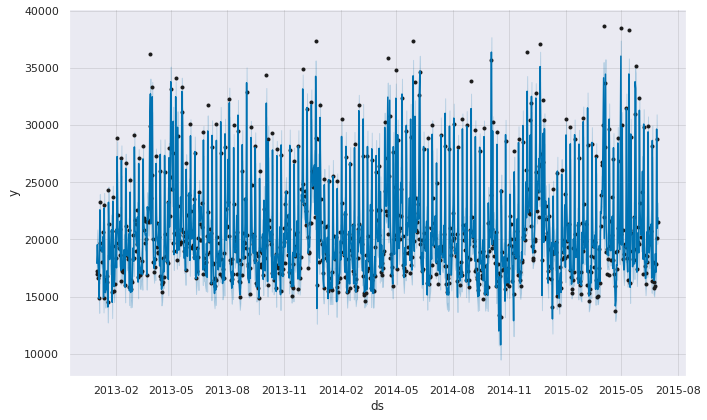

In [ ]:
regressors_m.plot(forecast_reg);

In [ ]:
plot_plotly(regressors_m, forecast_reg)

In [ ]:
plot_components_plotly(regressors_m, forecast_reg)

As seen above, this model perform better that all other model we previously regardless outliers.

The store 262 seems to be closed on weekends and opened on weekdays.The highest sales for this store is on Tuesday followed by Wednesday, Thursday and Mondays.
We have negative sales onFriday and weekends.Not having the complete picture of this store prevent me to draw any conclsion. Further questions should be asked to the Manager who as a domain knowledge on that matter. 

On a monthly basis, December and November have the highest sales.
On yearly basis sales are increasing yearly.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/fg2e3_qa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/0upbo68q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82130', 'data', 'file=/tmp/tmpajaw3sod/fg2e3_qa.json', 'init=/tmp/tmpajaw3sod/0upbo68q.json', 'output', 'file=/tmp/tmpajaw3sod/prophet_modelks6aex7e/prophet_model-20230116183114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


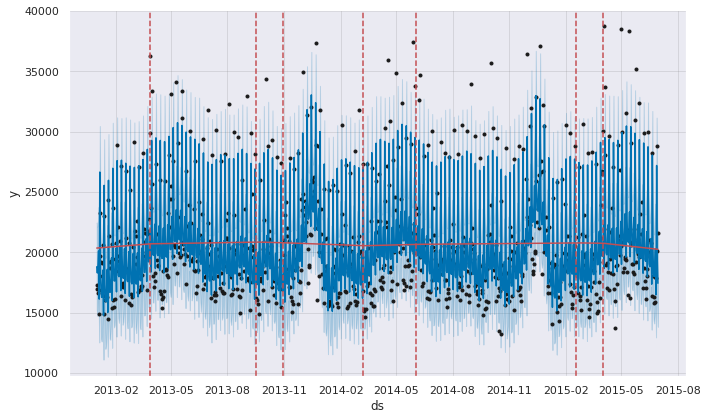

In [ ]:
reg_changepts_scale= Prophet(n_changepoints =20, changepoint_range =0.95, yearly_seasonality =True, changepoint_prior_scale =0.5)
reg_forecast = reg_changepts_scale.fit(ts_reg).predict(forecast_reg)
fig= holidays_changepts_scale.plot(reg_forecast);
a = add_changepoints_to_plot(fig.gca(), 
                             reg_changepts_scale,
                             reg_forecast)

## Cross validation & Model evaluation

### 1.  Cross validation model 1 - Sotre 262

Below we do cross-validation to assess prediction performance on a horizon of 365 days, starting with 730 days of training data in the first cutoff and then making predictions every 180 days. 

In [ ]:
# Prophet Cross Validation for model 1
store262_cv= cross_validation(store_262_m,
                              initial ='730 days',
                              period = '30 days',
                              horizon = '60 days',
                              parallel="processes")

INFO:prophet:Making 5 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-05-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcf51483c10>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/u82hgz2x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/jyi1sp5r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/h1fimfkz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12543', 'data', 'file=/tmp/tmpajaw3sod/u82hgz2x.json', 'init=/tmp/tmpajaw3sod/h1fimfkz.json', 'output', 'file=/tmp/tmpajaw3sod/prophet_modelftc9x_ev/prophet_model-20230116183116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/sj19zq43.json
18:31:16 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running 

In [ ]:
store262_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-01-02,21613.631,18072.791,25253.925,17216,2015-01-01
1,2015-01-03,17675.791,14077.837,21162.237,16657,2015-01-01
2,2015-01-04,28107.789,24226.888,31556.768,22058,2015-01-01
3,2015-01-05,19937.378,16356.629,23199.193,19144,2015-01-01
4,2015-01-06,17857.733,14271.620,21590.036,17713,2015-01-01


In [ ]:
store262_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
295,2015-06-26,21128.962,17462.494,24800.150,17936,2015-05-01
296,2015-06-27,17241.292,13659.939,20934.708,17864,2015-05-01
297,2015-06-28,27824.848,24006.587,31603.639,28817,2015-05-01
298,2015-06-29,19959.471,16358.643,23747.622,20112,2015-05-01
299,2015-06-30,18110.190,14355.703,21869.000,21554,2015-05-01


In [ ]:
# Performance metrics for store_62 model
store262_pmx = performance_metrics(store262_cv)
store262_pmx.sample(3)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
17,23 days,6353141.915,2520.544,2037.804,0.120,0.081,0.109,0.800
46,52 days,5552035.191,2356.276,1827.616,0.105,0.065,0.096,0.833
14,20 days,3550003.939,1884.145,1507.605,0.081,0.063,0.076,0.933


In [ ]:
store262_pmx.mean()

horizon     33 days 00:00:00
mse             12690764.415
rmse                3433.715
mae                 2295.827
mape                   0.110
mdape                  0.083
smape                  0.108
coverage               0.842
dtype: object

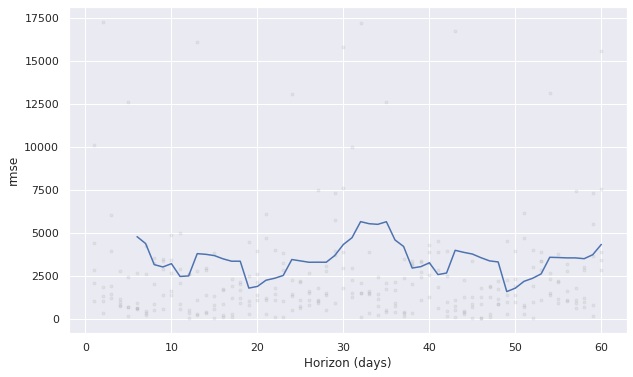

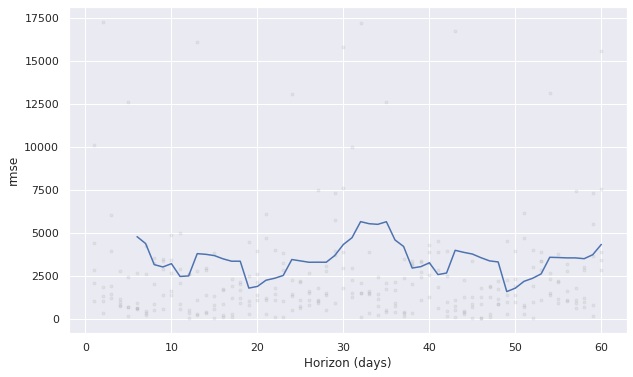

In [ ]:
# Plot cross validation metrics for store_262 model
plot_cross_validation_metric(store262_cv, metric ='rmse')

### 2.  Croos validation model 2 - holidays model

In [ ]:
holidays_cv= cross_validation(holidays_m,
                              initial ='730 days',
                              period = '30 days',
                              horizon = '60 days',
                              parallel="processes")

INFO:prophet:Making 5 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-05-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcf51059d60>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/0zuwzovq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/skq7v8k6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36182', 'data', 'file=/tmp/tmpajaw3sod/0zuwzovq.json', 'init=/tmp/tmpajaw3sod/skq7v8k6.json', 'output', 'file=/tmp/tmpajaw3sod/prophet_model5tw4ps12/prophet_model-20230116183154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/tofk065w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/d0o7e5fo.json
DEBU

In [ ]:
holidays_cv.head(7)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-01-02,21554.982,16127.910,26681.197,17216,2015-01-01
1,2015-01-03,17961.078,12698.013,23709.809,16657,2015-01-01
2,2015-01-04,28421.494,22598.125,34164.431,22058,2015-01-01
3,2015-01-05,20007.375,14596.511,25442.567,19144,2015-01-01
4,2015-01-06,17953.826,12395.414,23477.948,17713,2015-01-01
5,2015-01-07,17638.043,12413.153,22986.496,16582,2015-01-01
6,2015-01-08,18185.035,12454.232,23375.664,17544,2015-01-01


In [ ]:
holidays_cv.tail(7)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
293,2015-06-24,18554.453,12692.572,24101.259,16249,2015-05-01
294,2015-06-25,19271.250,13388.708,25274.590,15896,2015-05-01
295,2015-06-26,20742.598,15200.377,25984.447,17936,2015-05-01
296,2015-06-27,17168.629,11551.195,22647.799,17864,2015-05-01
297,2015-06-28,27738.404,22345.662,33855.338,28817,2015-05-01
298,2015-06-29,20342.738,14563.551,25910.802,20112,2015-05-01
299,2015-06-30,18468.466,12944.009,24300.402,21554,2015-05-01


In [ ]:
# Performance metrics for holidays model
holidays_pmx = performance_metrics(holidays_cv)
holidays_pmx.sample(3)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
15,21 days,4658009.887,2158.242,1665.786,0.094,0.061,0.087,0.967
14,20 days,3508041.768,1872.977,1486.384,0.079,0.058,0.075,1.000
19,25 days,11071311.728,3327.358,2258.172,0.120,0.075,0.114,0.933


In [ ]:
holidays_pmx[['mse','rmse', 'mae','mape','mdape','smape']].mean()

mse     12602723.551
rmse        3421.630
mae         2293.773
mape           0.110
mdape          0.081
smape          0.108
dtype: float64

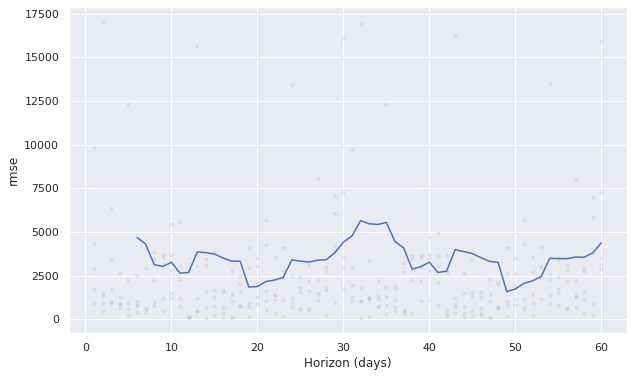

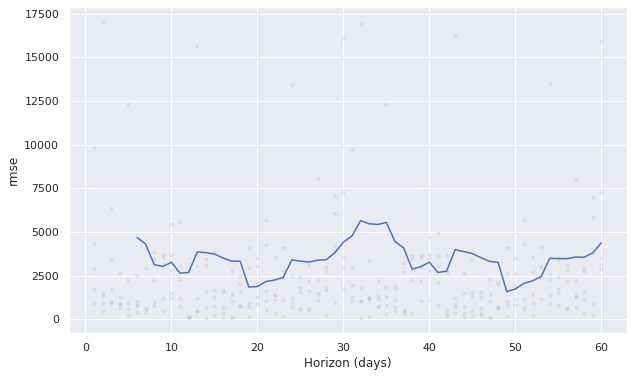

In [ ]:
# Plot cross validation metrics for holidays model
plot_cross_validation_metric(holidays_cv, metric ='rmse')

### 3.  cross validation for us holidays model

In [ ]:
us_hol_cv= cross_validation(us_hol_m,
                            initial ='730 days',
                            period = '30 days',
                            horizon = '60 days')

INFO:prophet:Making 5 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-05-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/kysvo1w9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/2h7ypto6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29016', 'data', 'file=/tmp/tmpajaw3sod/kysvo1w9.json', 'init=/tmp/tmpajaw3sod/2h7ypto6.json', 'output', 'file=/tmp/tmpajaw3sod/prophet_model83ntg9xa/prophet_model-20230116183610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/4e4jqgnb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/cdga0coj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

In [ ]:
us_hol_cv.head(7)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-01-02,21501.541,18052.931,24757.883,17216,2015-01-01
1,2015-01-03,17927.100,14124.284,21455.192,16657,2015-01-01
2,2015-01-04,28389.034,24761.668,31519.049,22058,2015-01-01
3,2015-01-05,19954.267,16376.951,23390.614,19144,2015-01-01
4,2015-01-06,17916.989,14461.629,21648.658,17713,2015-01-01
5,2015-01-07,17570.103,14014.569,21132.195,16582,2015-01-01
6,2015-01-08,18114.685,14297.703,21737.337,17544,2015-01-01


In [ ]:
us_hol_cv.tail(7)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
293,2015-06-24,18482.079,14912.840,22253.030,16249,2015-05-01
294,2015-06-25,19196.885,15502.884,22951.761,15896,2015-05-01
295,2015-06-26,20684.482,16659.298,24254.158,17936,2015-05-01
296,2015-06-27,17121.453,13616.159,21002.164,17864,2015-05-01
297,2015-06-28,27691.420,23875.281,31222.880,28817,2015-05-01
298,2015-06-29,20309.109,16313.807,24177.751,20112,2015-05-01
299,2015-06-30,18428.659,14549.467,22224.521,21554,2015-05-01


In [ ]:
# Performance metrics for holidays model
us_holidays_pmx = performance_metrics(us_hol_cv)
us_holidays_pmx.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,6 days,21949068.918,4684.983,2757.256,0.109,0.058,0.116,0.800
1,7 days,18487264.840,4299.682,2379.456,0.097,0.048,0.101,0.833
2,8 days,9733150.084,3119.800,2040.760,0.096,0.050,0.094,0.800
3,9 days,9079392.419,3013.203,1986.821,0.099,0.048,0.096,0.800
4,10 days,10549660.849,3248.024,2261.017,0.117,0.075,0.111,0.767


In [ ]:
us_holidays_pmx.mean()

horizon     33 days 00:00:00
mse             13128469.364
rmse                3499.622
mae                 2323.903
mape                   0.111
mdape                  0.082
smape                  0.110
coverage               0.827
dtype: object

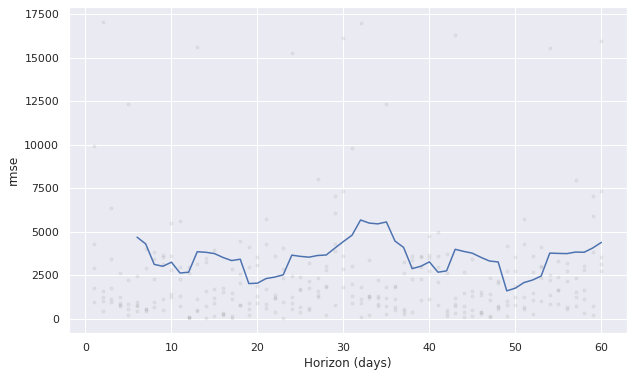

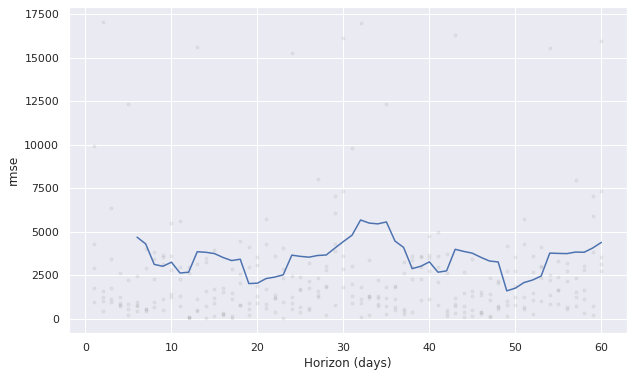

In [ ]:
# Plot cross validation metrics for holidays model
plot_cross_validation_metric(us_hol_cv, metric ='rmse')

### 4.  Cross validation for regressors model

In [ ]:
reg_cv= cross_validation(regressors_m, initial ='730 days',period = '30 days',horizon = '60 days')

INFO:prophet:Making 5 forecasts with cutoffs between 2015-01-01 00:00:00 and 2015-05-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/hnxorpho.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/tnpcthil.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38594', 'data', 'file=/tmp/tmpajaw3sod/hnxorpho.json', 'init=/tmp/tmpajaw3sod/tnpcthil.json', 'output', 'file=/tmp/tmpajaw3sod/prophet_modelt9lzyumx/prophet_model-20230116184037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/2wbgp69g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpajaw3sod/_isx999j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

In [ ]:
reg_cv.tail(7)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
293,2015-06-24,16692.481,15389.821,17967.272,16249,2015-05-01
294,2015-06-25,17331.239,16070.843,18653.938,15896,2015-05-01
295,2015-06-26,19049.475,17730.140,20368.570,17936,2015-05-01
296,2015-06-27,17394.288,16065.565,18681.569,17864,2015-05-01
297,2015-06-28,29918.541,28578.378,31232.015,28817,2015-05-01
298,2015-06-29,21237.822,19999.647,22534.921,20112,2015-05-01
299,2015-06-30,22132.357,20786.779,23487.056,21554,2015-05-01


In [ ]:
# Performance metrics for holidays model
reg_pmx = performance_metrics(reg_cv)
reg_pmx.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,6 days,2509050.340,1583.998,1178.807,0.053,0.046,0.052,0.633
1,7 days,2373364.200,1540.573,1062.186,0.049,0.036,0.048,0.667
2,8 days,1645775.730,1282.878,977.742,0.049,0.046,0.047,0.667
3,9 days,1414052.267,1189.139,876.423,0.045,0.031,0.044,0.700
4,10 days,1262830.221,1123.757,835.384,0.044,0.031,0.043,0.700


In [ ]:
store262_pmx['rmse'].mean(), holidays_pmx['rmse'].mean(), us_holidays_pmx['rmse'].mean(),reg_pmx['rmse'].mean()

(3433.715029874095, 3421.6303157698144, 3499.6222728045545, 1238.8201060380907)

In [ ]:
store262_pmx['mae'].mean(), holidays_pmx['mae'].mean(), us_holidays_pmx['mae'].mean(),reg_pmx['mae'].mean()

(2295.82715013915, 2293.773148203913, 2323.902751548161, 907.097378340681)

In [ ]:
store262_pmx['smape'].mean(), holidays_pmx['smape'].mean(), us_holidays_pmx['smape'].mean(),reg_pmx['smape'].mean()

(0.10838644206900899,
 0.10806934675344639,
 0.10952510124751373,
 0.043604793664901415)

### Conclusion:

Based on the evaluation metrix, we can conclude that, the model with aadd regressors outperm all other model followed by holidays model and the model with us custom holidays did not perform well. Either US is not the country where the store 262 is located or the us holidays have less effect on sales in comparison to state and holidays.

Note that, the forecast results are for the store 262 only not for all other stores which the result may be different. Assuming certain store may perform similarily or differentely depending on their own reality and location, sales strategies, marketing strategies like promotion or discounts, or pricing to note just that.